# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_2600\3756830549.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Auxiliar functions

In [2]:
def sign(x):
    if x > 0:
        return 1
    
    elif x == 0:
        return 0
    else:
        return -1

def create_database(min_value, max_value, d, number_of_points):
    """Creates a database of random points with a specified range and number of dimensions."""
    return np.random.uniform(min_value, max_value, (number_of_points, d + 2))

def get_target_points(min_value, max_value, d):
    """Generates random points representing the endpoints of a line."""
    return np.random.uniform(min_value, max_value, (2, d))

def get_target_function(point1, point2):
    """Calculates the coefficients of the line passing through two random points."""
    a = (point2[1] - point1[1]) / (point2[0] - point1[0])  # Slope
    b = point1[1] - a * point1[0]  # Intercept
    return [a, b]

def is_above_line(point, coefficients):
    """Checks if a point is above a line defined by its coefficients."""
    return sign(point[1] - (coefficients[0] * point[0] + coefficients[1]))

def target_function_to_database(database, coefficients):
    """Assigns labels to points in the database based on their position relative to a line."""
    for i in range(len(database)):
        x = database[i][1]
        y = database[i][2]

        database[i][0] = 1 # Add x0

        database[i][-1] = is_above_line([x, y], coefficients) # Add yn
    
    return database

def calculate_out_of_sample_error(g, test_database):
    X_test = test_database[:, :3]  # Pega as colunas x0, x1, x2 (incluindo bias)
    y_test = test_database[:, -1]  # Pega os rótulos

    predictions = np.sign(X_test @ g)
    error_outside = np.mean(predictions != y_test)
    return error_outside

def pla(target_database, max_iterations, initial_w = None):

    iterations = 0

    if initial_w is not None:
        w = initial_w
    else: 
        w = np.array([0, 0, 0]) 
    while iterations < max_iterations:
        iterations+=1
        
        misclassified_points_index = []

        for i in range(len(target_database)):
            point = target_database[i]
            if sign(point[:3] @ w) != point[3]:
                misclassified_points_index.append(i)
        if len(misclassified_points_index) == 0: # Convergence
            break
        
        random_index = random.choice(misclassified_points_index)        
        misclassified_point = target_database[random_index]

        w = w + (misclassified_point[3] * misclassified_point[:3])
    
    return w,iterations   

def pla_pocket(target_database, max_iterations, initial_w = None):

    iterations = 0

    if initial_w is not None:
        w = initial_w
    else: 
        w = np.array([0, 0, 0]) 

    best_w = w
    best_error = np.mean(np.sign(target_database[:, :3] @ w) != target_database[:, 3])


 
    while iterations < max_iterations:
        iterations+=1
        
        misclassified_points_index = []

        for i in range(len(target_database)):
            point = target_database[i]
            if sign(point[:3] @ w) != point[3]:
                misclassified_points_index.append(i)

        if len(misclassified_points_index) == 0: # Convergence
            break
        
        random_index = random.choice(misclassified_points_index)        
        misclassified_point = target_database[random_index]

        w = w + (misclassified_point[3] * misclassified_point[:3])

        current_error = np.mean(np.sign(target_database[:, :3] @ w) != target_database[:, 3])
        if current_error < best_error:
            best_w = w
            best_error = current_error
    
    return best_w,best_error,iterations   


def linear_regression(d, N, target_train_database):
    
    X = target_train_database[:, :d+1]  # Pega as colunas x0, x1, ..., xd
    y = target_train_database[:, -1]    # Pega os rótulos

    # Calcula g = (X^T X)^-1 X^T y
    X_transpose = X.T
    pseudo_inverse = np.linalg.inv(X_transpose @ X) @ X_transpose
    g = pseudo_inverse @ y

    predictions = np.sign(X @ g)
    error_inside = np.mean(predictions != y)
    
    return g, error_inside

def run_linear_regression(d, N, number_of_executions, test_size):
    sum_error_inside = 0
    sum_error_outside = 0

    for i in range(number_of_executions):
        train_database = create_database(-1, 1, d, N)
        random_points = get_target_points(-1, 1, d)
        coefficients = get_target_function(random_points[0], random_points[1])
        target_train_database = target_function_to_database(train_database, coefficients)

        g, error_inside = linear_regression(d, N, target_train_database)

        test_database = create_database(-1, 1, d, test_size)
        target_test_database = target_function_to_database(test_database, coefficients)

        error_outside = calculate_out_of_sample_error(g, target_test_database)
        sum_error_inside += error_inside
        sum_error_outside += error_outside

    x1 = target_train_database[:, 1]
    x2 = target_train_database[:, 2]
    categories = target_train_database[:, 3]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # First plot: Função Target - f(x) - Last Iteration
    ax1 = axes[0]
    colors = ['red' if category == -1 else 'blue' for category in categories]
    ax1.scatter(x1, x2, c=colors, marker='o', label='Pontos')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.grid(True)
    ax1.set_title('Target Function - f(x) - Last Iteration')

    x_vals = np.array(ax1.get_xlim())
    y_vals = coefficients[1] + coefficients[0] * x_vals
    ax1.plot(x_vals, y_vals, '--')
    ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[0], color='lightcoral', alpha=0.5)
    ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[1], color='skyblue', alpha=0.5)

    # Second plot: Hipótese g(x)
    ax2 = axes[1]
    x1 = target_test_database[:, 1]
    x2 = target_test_database[:, 2]
    categories = np.sign(target_test_database[:, :3] @ g)
    colors = ['red' if category == -1 else 'blue' for category in categories]
    ax2.scatter(x1, x2, c=colors, marker='o', s=2)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel('Eixo X')
    ax2.set_ylabel('Eixo Y')
    ax2.grid(True)
    ax2.set_title('Hypothesis Function - g(x) - Last Iteration')

    x_vals = np.array(ax2.get_xlim())
    y_vals = (-1 * (g[0] + g[1] * x_vals)) / g[2]
    ax2.plot(x_vals, y_vals, '--')

    real_y_vals = coefficients[1] + coefficients[0] * x_vals
    ax2.fill_between(x_vals, real_y_vals, ax2.get_ylim()[0], color='lightcoral', alpha=0.5)
    ax2.fill_between(x_vals, real_y_vals, ax2.get_ylim()[1], color='skyblue', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return sum_error_inside / number_of_executions, sum_error_outside / number_of_executions

def run_linear_and_pla(d, N, max_iter, number_of_executions, test_size):
    sum_divergence_probability = 0
    sum_iterations = 0

    for i in range(number_of_executions):
        train_database = create_database(-1, 1, d, N)
        target_points = get_target_points(-1, 1, d)
        coefficients = get_target_function(target_points[0], target_points[1])
        target_train_database = target_function_to_database(train_database, coefficients)

        g, error_inside = linear_regression(d, N, target_train_database)
        initial_w = g

        target_database = target_function_to_database(train_database, coefficients)
        w, iteration = pla(target_database, max_iter, initial_w)
        
        test_database = create_database(-1, 1, d, test_size)
        target_test_database = target_function_to_database(test_database, coefficients)

        divergence_probability = calculate_out_of_sample_error(w, target_test_database)

        sum_divergence_probability += divergence_probability
        sum_iterations += iteration

    # Plotting the graphs
    x1 = target_train_database[:, 1]
    x2 = target_train_database[:, 2]
    categories = target_train_database[:, 3]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    # First plot: Função Target - f(x) - Last Iteration
    ax1 = axes[0]
    colors = ['red' if category == -1 else 'blue' for category in categories]
    ax1.scatter(x1, x2, c=colors, marker='o', label='Pontos')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.grid(True)
    ax1.set_title('Target Function - f(x) - Last Iteration')

    x_vals = np.array(ax1.get_xlim())
    y_vals = coefficients[1] + coefficients[0] * x_vals
    ax1.plot(x_vals, y_vals, '--')
    ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[0], color='lightcoral', alpha=0.5)
    ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[1], color='skyblue', alpha=0.5)

    # Second plot: Hipótese inicial g(x) com pesos iniciais
    ax2 = axes[1]
    colors = ['red' if category == -1 else 'blue' for category in categories]
    ax2.scatter(x1, x2, c=colors, marker='o')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel('Eixo X')
    ax2.set_ylabel('Eixo Y')
    ax2.grid(True)
    ax2.set_title('Initial Hypothesis Function - g(x) - Last Iteration')

    y_vals_initial = (-1 * (initial_w[0] + initial_w[1] * x_vals)) / initial_w[2]
    ax2.plot(x_vals, y_vals_initial, '--')
    ax2.fill_between(x_vals, y_vals, ax2.get_ylim()[0], color='lightcoral', alpha=0.5)
    ax2.fill_between(x_vals, y_vals, ax2.get_ylim()[1], color='skyblue', alpha=0.5)

    # Third plot: Hipótese final g(x) após PLA
    ax3 = axes[2]
    x1 = target_test_database[:, 1]
    x2 = target_test_database[:, 2]
    categories = np.sign(target_test_database[:, :3] @ w)
    colors = ['red' if category == -1 else 'blue' for category in categories]
    ax3.scatter(x1, x2, c=colors, marker='o', s=2)
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax3.set_xlabel('Eixo X')
    ax3.set_ylabel('Eixo Y')
    ax3.grid(True)
    ax3.set_title('Hypothesis Function - g(x) - Last Iteration')

    y_vals_final = (-1 * (w[0] + w[1] * x_vals)) / w[2]
    ax3.plot(x_vals, y_vals_final, '--')

    real_y_vals = coefficients[1] + coefficients[0] * x_vals
    ax3.fill_between(x_vals, real_y_vals, ax3.get_ylim()[0], color='lightcoral', alpha=0.5)
    ax3.fill_between(x_vals, real_y_vals, ax3.get_ylim()[1], color='skyblue', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return sum_divergence_probability / number_of_executions, sum_iterations / number_of_executions

def invert_labels(target_database, percentage=0.1):
    indices_to_invert = np.random.choice(range(len(target_database)), size=int(percentage * len(target_database)), replace=False)
    target_database[indices_to_invert, 3] *= -1
    return target_database

def run_pla_pocket(d, N, max_iter, number_of_executions, test_size, use_linear_regression = False):
    sum_out_of_sample_error = 0
    sum_in_sample_error = 0
    for i in range(number_of_executions):
        train_database = create_database(-1, 1, d, N)
        target_points = get_target_points(-1, 1, d)
        coefficients = get_target_function(target_points[0], target_points[1])
        target_train_database = target_function_to_database(train_database, coefficients)

        # Invert labels
        target_train_database = invert_labels(target_train_database, 0.1)

        if use_linear_regression:
            g, error_inside = linear_regression(d, N, target_train_database)
            initial_w = g
        else:
            initial_w = np.array([0, 0, 0])

        w, in_sample_error, iteration = pla_pocket(target_train_database, max_iter, initial_w)
        
        test_database = create_database(-1, 1, d, test_size)
        target_test_database = target_function_to_database(test_database, coefficients)

        out_of_sample_error = calculate_out_of_sample_error(w, target_test_database)

        sum_out_of_sample_error += out_of_sample_error
        sum_in_sample_error += in_sample_error

    if use_linear_regression:

        x1 = target_train_database[:, 1]
        x2 = target_train_database[:, 2]
        categories = target_train_database[:, 3]

        # Create subplots
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))

        # First plot: Função Target - f(x) - Last Iteration
        ax1 = axes[0]
        colors = ['red' if category == -1 else 'blue' for category in categories]
        ax1.scatter(x1, x2, c=colors, marker='o', label='Pontos')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.grid(True)
        ax1.set_title('Target Function - f(x) - Last Iteration')

        x_vals = np.array(ax1.get_xlim())
        y_vals = coefficients[1] + coefficients[0] * x_vals
        ax1.plot(x_vals, y_vals, '--')
        ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[0], color='lightcoral', alpha=0.5)
        ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[1], color='skyblue', alpha=0.5)

        # Second plot: Hipótese inicial g(x) com pesos iniciais
        ax2 = axes[1]
        colors = ['red' if category == -1 else 'blue' for category in categories]
        ax2.scatter(x1, x2, c=colors, marker='o')
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        ax2.set_xlabel('Eixo X')
        ax2.set_ylabel('Eixo Y')
        ax2.grid(True)
        ax2.set_title('Initial Hypothesis Function - g(x) - Last Iteration')

        y_vals_initial = (-1 * (initial_w[0] + initial_w[1] * x_vals)) / initial_w[2]
        ax2.plot(x_vals, y_vals_initial, '--')
        ax2.fill_between(x_vals, y_vals, ax2.get_ylim()[0], color='lightcoral', alpha=0.5)
        ax2.fill_between(x_vals, y_vals, ax2.get_ylim()[1], color='skyblue', alpha=0.5)

        # Third plot: Hipótese final g(x) após PLA
        ax3 = axes[2]
        x1 = target_test_database[:, 1]
        x2 = target_test_database[:, 2]
        categories = np.sign(target_test_database[:, :3] @ w)
        colors = ['red' if category == -1 else 'blue' for category in categories]
        ax3.scatter(x1, x2, c=colors, marker='o', s=2)
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(-1, 1)
        ax3.set_xlabel('Eixo X')
        ax3.set_ylabel('Eixo Y')
        ax3.grid(True)
        ax3.set_title('Hypothesis Function - g(x) - Last Iteration')

        y_vals_final = (-1 * (w[0] + w[1] * x_vals)) / w[2]
        ax3.plot(x_vals, y_vals_final, '--')

        real_y_vals = coefficients[1] + coefficients[0] * x_vals
        ax3.fill_between(x_vals, real_y_vals, ax3.get_ylim()[0], color='lightcoral', alpha=0.5)
        ax3.fill_between(x_vals, real_y_vals, ax3.get_ylim()[1], color='skyblue', alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        x1 = target_train_database[:, 1]
        x2 = target_train_database[:, 2]
        categories = target_train_database[:, 3]

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        # First plot: Função Target - f(x) - Last Iteration
        ax1 = axes[0]
        colors = ['red' if category == -1 else 'blue' for category in categories]
        ax1.scatter(x1, x2, c=colors, marker='o', label='Pontos')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.grid(True)
        ax1.set_title('Target Function - f(x) - Last Iteration')

        x_vals = np.array(ax1.get_xlim())
        y_vals = coefficients[1] + coefficients[0] * x_vals
        ax1.plot(x_vals, y_vals, '--')
        ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[0], color='lightcoral', alpha=0.5)
        ax1.fill_between(x_vals, y_vals, ax1.get_ylim()[1], color='skyblue', alpha=0.5)

        # Second plot: Hipótese g(x)
        ax2 = axes[1]
        x1 = target_test_database[:, 1]
        x2 = target_test_database[:, 2]
        hyphotesis_categories = np.sign(target_test_database[:, :3] @ w)
        colors = ['red' if category == -1 else 'blue' for category in hyphotesis_categories]
        ax2.scatter(x1, x2, c=colors, marker='o', s=2)
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        ax2.set_xlabel('Eixo X')
        ax2.set_ylabel('Eixo Y')
        ax2.grid(True)
        ax2.set_title('Hypothesis Function - g(x) - Last Iteration')

        x_vals = np.array(ax2.get_xlim())
        y_vals = (-1 * (w[0] + w[1] * x_vals)) / w[2]
        ax2.plot(x_vals, y_vals, '--')

        real_y_vals = coefficients[1] + coefficients[0] * x_vals
        ax2.fill_between(x_vals, real_y_vals, ax2.get_ylim()[0], color='lightcoral', alpha=0.5)
        ax2.fill_between(x_vals, real_y_vals, ax2.get_ylim()[1], color='skyblue', alpha=0.5)

        plt.tight_layout()
        plt.show()


    return sum_in_sample_error / number_of_executions, sum_out_of_sample_error / number_of_executions


## 1 - Considere N = 100. Use Regressão Linear para encontrar g e calcule Ein, a fração de pontos dentro-de-amostra que foram classificados incorretamente (armazene os g’s pois eles serão usados no item seguinte). Repita o experimento 1000 vezes. Qual dos valores abaixo é mais próximo do Ein médio?

## 2 - Agora, gere 1000 pontos novos e use eles para estimar o Eout dos g’s que você encontrou no item anterior. Novamente, realize 1000 execuções. QUal dos valores abaixo é mais próximo do Eout médio?

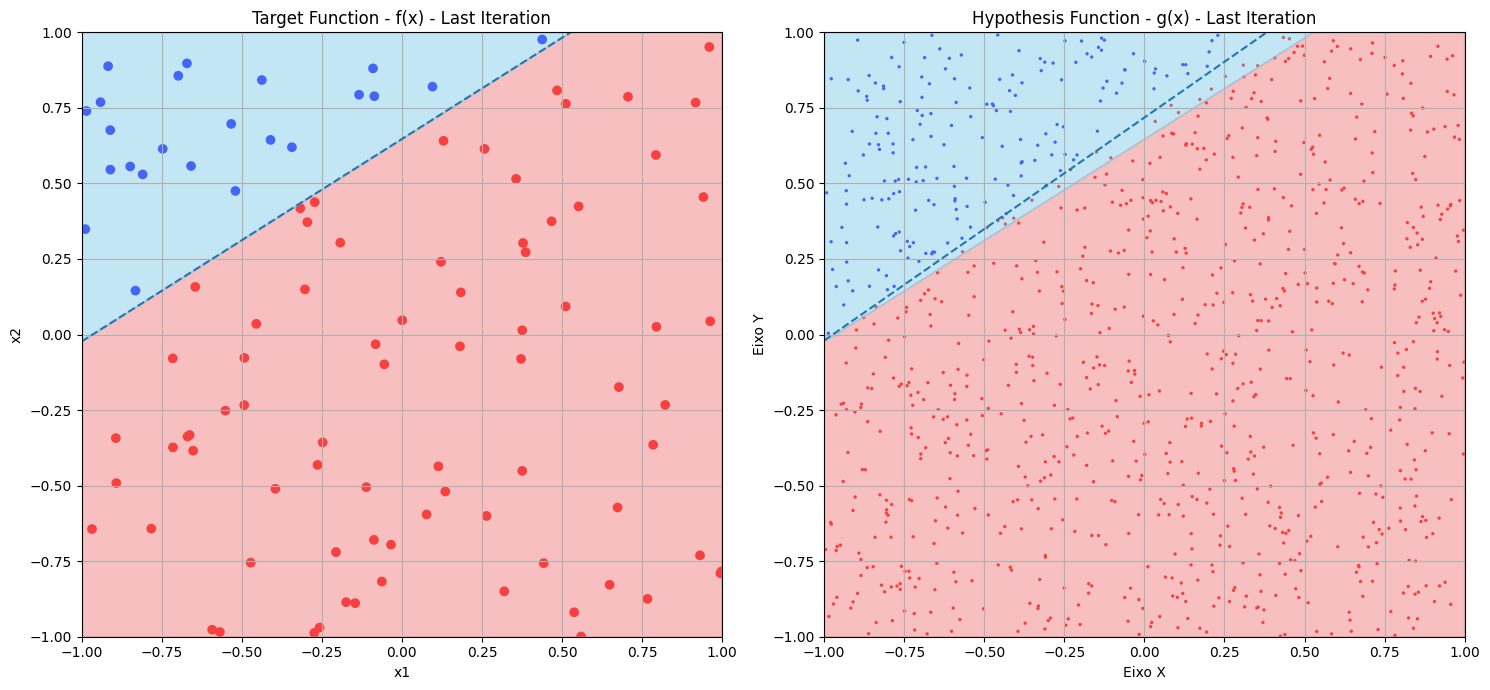

Linear Regression for N = 100
Mean Inside Error = 0.03947000000000008
Mean Outside error = 0.048497999999999965


In [3]:
mean_error_inside, mean_error_outside = run_linear_regression(d=2,N=100,number_of_executions=1000, test_size=1000)
print("Linear Regression for N = 100")
print(f"Mean Inside Error = {mean_error_inside}")
print(f"Mean Outside error = {mean_error_outside}")

## 3 - Agora, considere N = 10. Depois de encontrar os pesos usando Regressão Linear, use-os como um vetor de pesos iniciais para o Algoritmo de Aprendizagem Perceptron (PLA). Execute o PLA até que ele convirja num vetor final de pesos que separa perfeitamente os pontos dentro-de-amostra. Dentre as opções abaixo, qual é mais próxima do número médio de iterações (sobre 1000 execuções) que o PLA demora para convergir?

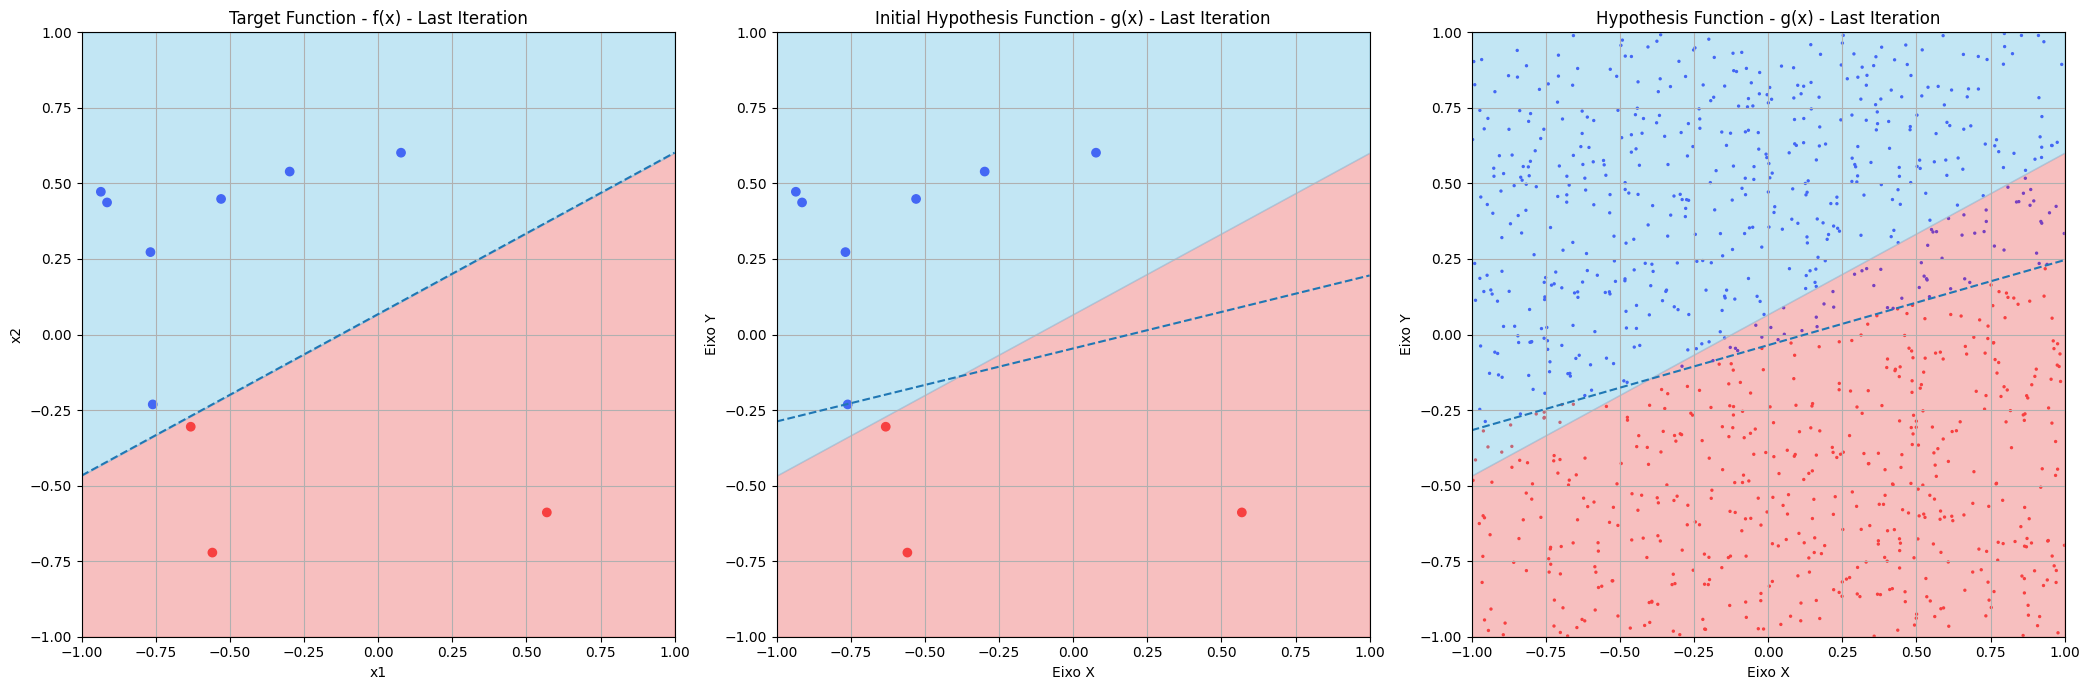

PLA for N = 10
Mean Divergence Probability = 0.09953800000000014
Mean Iterations = 4.223


In [4]:
mean_divergence_probability, mean_iterations = run_linear_and_pla(d=2,N=10,max_iter=10000,number_of_executions=1000, test_size=1000)
print("PLA for N = 10")
print(f"Mean Divergence Probability = {mean_divergence_probability}")
print(f"Mean Iterations = {mean_iterations}")


## 4 - Vamos agora avaliar o desempenho da versão pocket do PLA em um conjunto de dados que não é linearmente separável. Para criar este conjunto, gere uma base de treinamento com N2 pontos como foi feito até agora, mas selecione aleatoriamente 10% dos pontos e inverta seus rótulos. Em seguida, implemente a versão pocket do PLA, treine-a neste conjunto não-linearmente separável, e avalie seu Eout numa nova base de N2 pontos na qual você não aplicará nenhuma inversão de rótulos. Repita para 1000 execuções, e mostre o Ein e Eout médios para as seguintes configurações (não esqueça dos gráficos scatterplot, como anteriormente):

### Inicializando os pesos com 0; i = 10; N1 = 100; N2 = 1000.

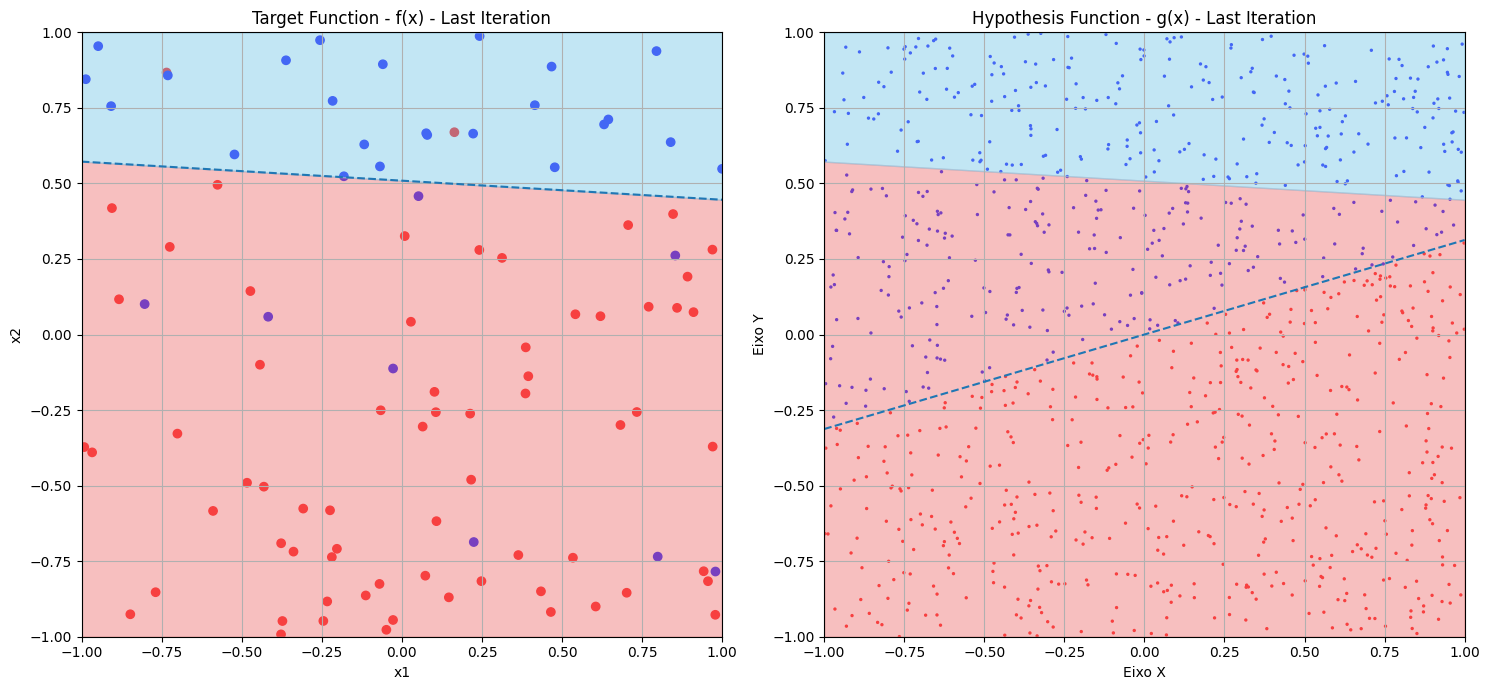

PLA Pocket for weights = 0, N1=100 and N2=1000
Mean Inside Error = 0.17576999999999934
Mean Outside error = 0.11400599999999986


In [5]:
in_error, out_error = run_pla_pocket(d=2, N=100, max_iter=10, number_of_executions=1000, test_size=1000, use_linear_regression=False)
print("PLA Pocket for weights = 0, N1=100 and N2=1000")
print(f"Mean Inside Error = {in_error}")
print(f"Mean Outside error = {out_error}")

### Inicializando os pesos com 0; i = 50; N1 = 100; N2 = 1000.

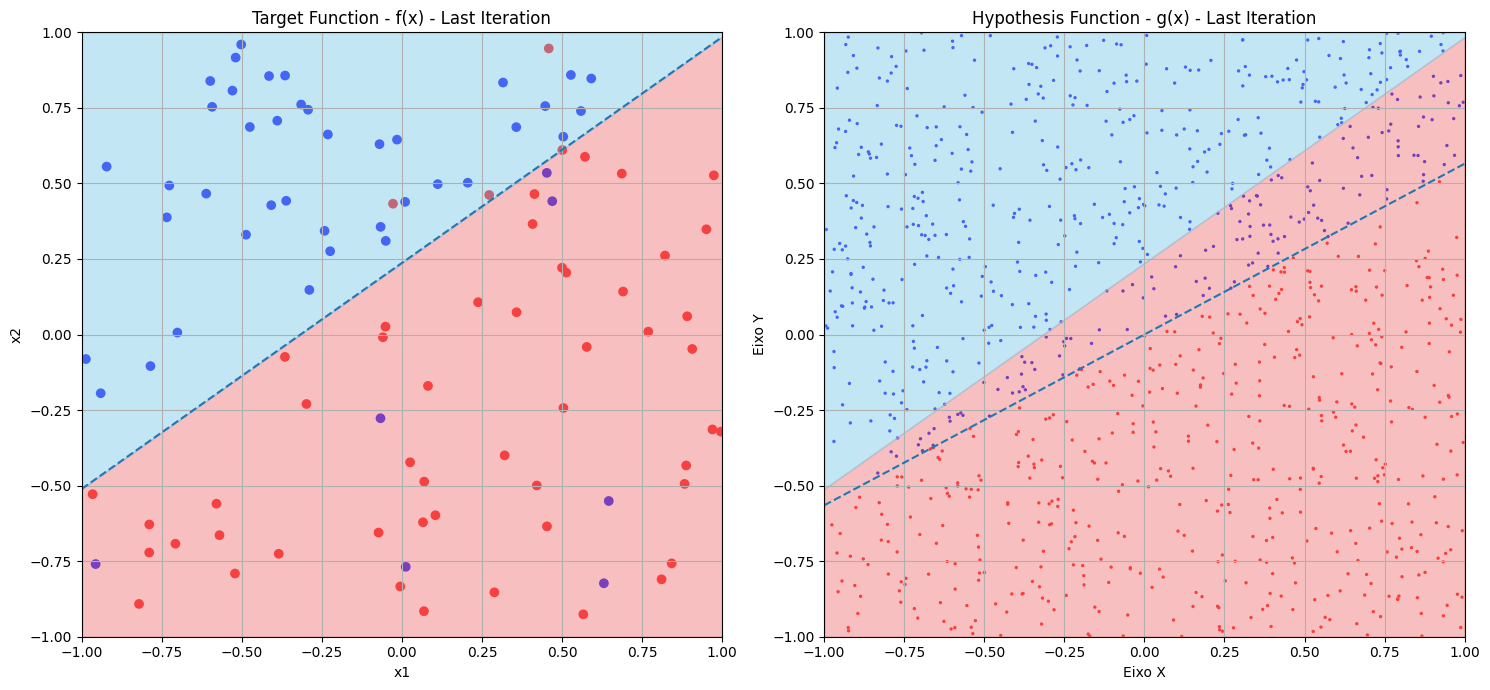

PLA Pocket for weights = 0, N1=100 and N2=1000
Mean Inside Error = 0.12808999999999993
Mean Outside error = 0.05957900000000007


In [6]:
in_error, out_error = run_pla_pocket(d=2, N=100, max_iter=50, number_of_executions=1000, test_size=1000, use_linear_regression=False)
print("PLA Pocket for weights = 0, N1=100 and N2=1000")
print(f"Mean Inside Error = {in_error}")
print(f"Mean Outside error = {out_error}")    

### Inicializando os pesos com Regressão Linear; i = 10; N1 = 100; N2 = 1000.

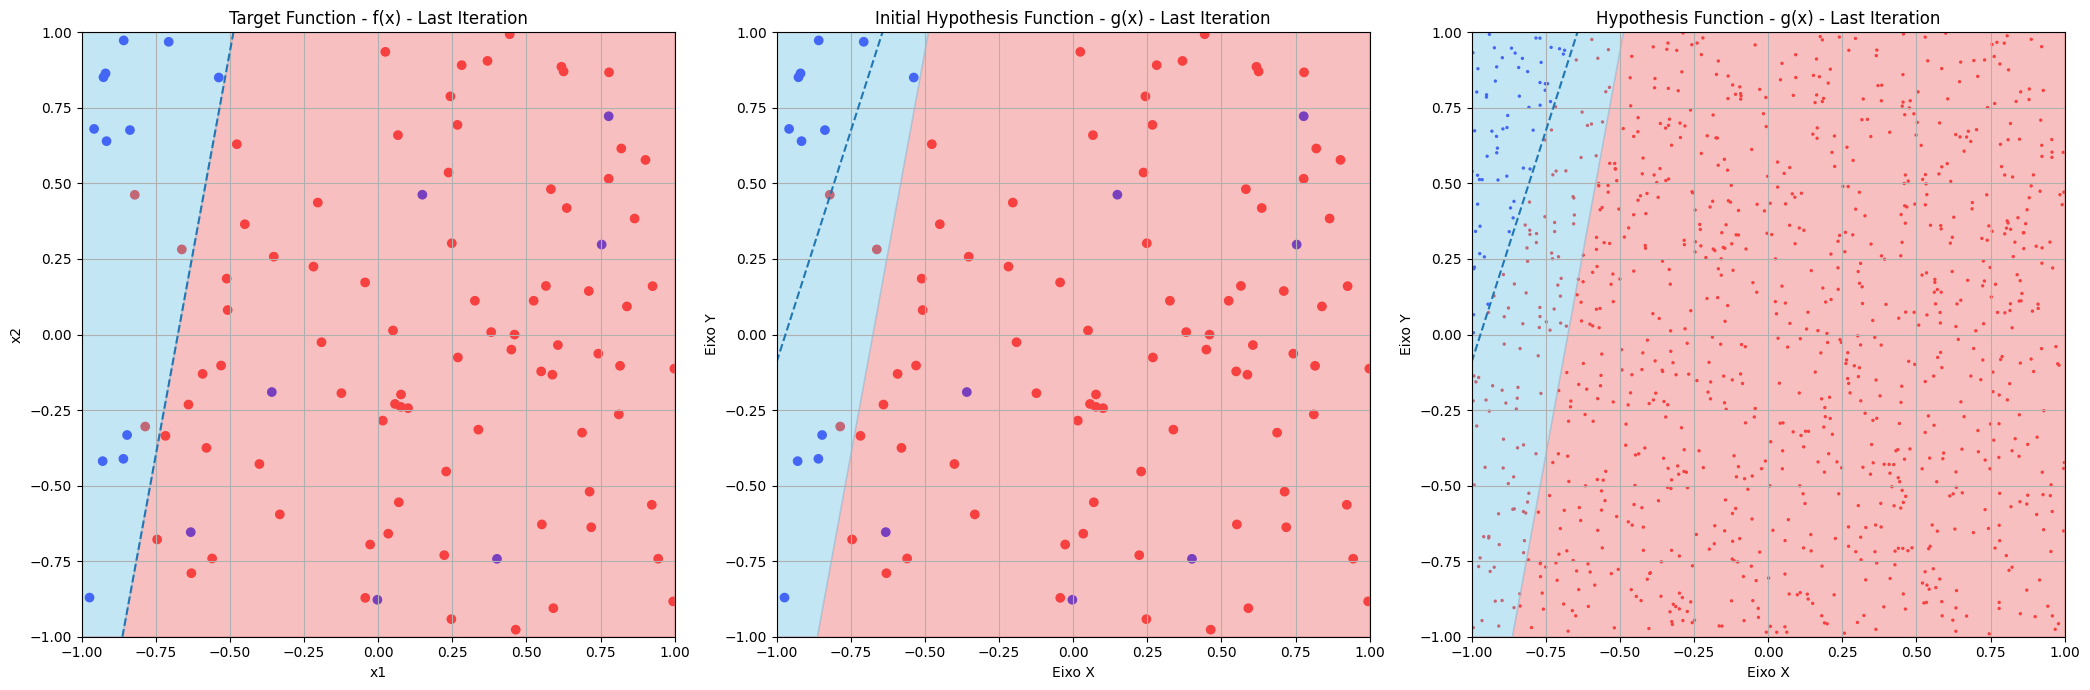

PLA Pocket for weights = 0, N1=100 and N2=1000
Mean Inside Error = 0.12998999999999994
Mean Outside error = 0.05541699999999996


In [7]:
in_error, out_error = run_pla_pocket(d=2, N=100, max_iter=10, number_of_executions=1000, test_size=1000, use_linear_regression=True)
print("PLA Pocket for weights = 0, N1=100 and N2=1000")
print(f"Mean Inside Error = {in_error}")
print(f"Mean Outside error = {out_error}")

### Inicializando os pesos com Regressão Linear; i = 50; N1 = 100; N2 = 1000.

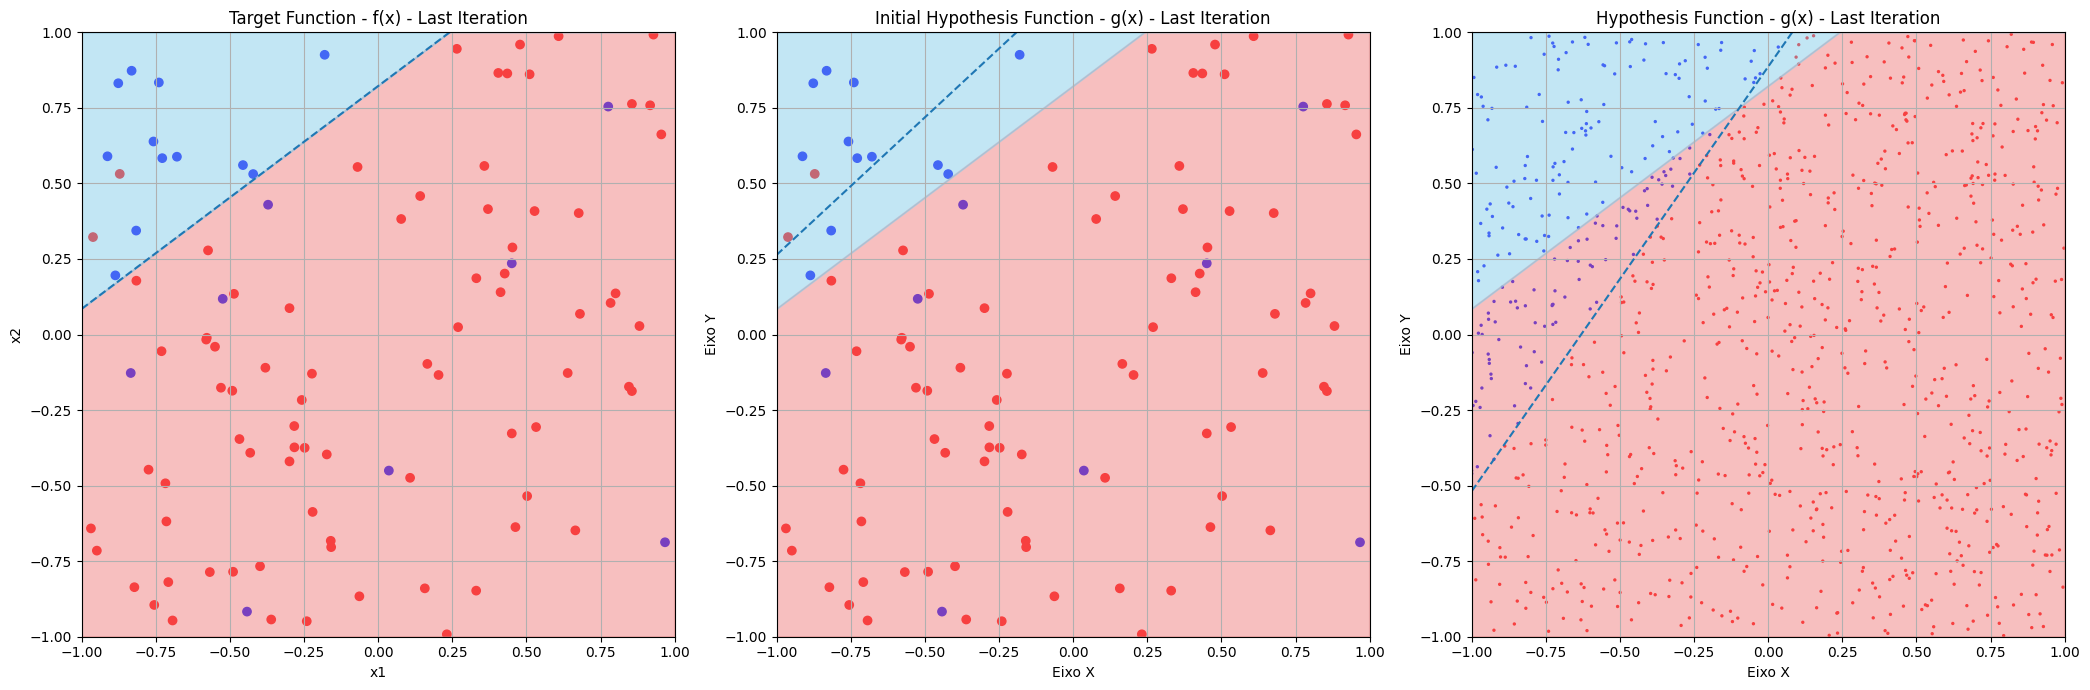

PLA Pocket for weights = 0, N1=100 and N2=1000
Mean Inside Error = 0.11925999999999985
Mean Outside error = 0.04561499999999997


In [8]:
in_error, out_error = run_pla_pocket(d=2, N=100, max_iter=50, number_of_executions=1000, test_size=1000, use_linear_regression=True)
print("PLA Pocket for weights = 0, N1=100 and N2=1000")
print(f"Mean Inside Error = {in_error}")
print(f"Mean Outside error = {out_error}")
